### In this notebook we used  pretrained Inception model

Note that the input image format for this model is different than for
the VGG16 and ResNet models (299x299 instead of 224x224),
and that the input preprocessing function is also different (same as Xception).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Importing the libraries

In [2]:
import torch
import torch.backends.cudnn as cudnn

import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Function, Variable
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


from pathlib import Path
import os
import copy
import math
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
import time as time

#### Checking whether the GPU is active

In [3]:
torch.backends.cudnn.enabled

True

In [4]:
torch.cuda.is_available()

True

### Hyper Parameters

In [5]:
EPOCH= 5

BchSz=4 # BATCHSIZE

# Learning Rate
learning_rate = 0.0001

# Dropout rate
Dropout=0.5

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()   # cross entropy loss

Dataset paths

In [7]:
PATH = Path("/home/saman/Saman/data/Image_Data01/")
train_path = PATH / 'train' / 'Total'
valid_path = PATH / 'valid' / 'Total'
test_path = PATH / 'test' / 'Total'

### Loading data set (including augmentations)

#### Train the model with rescaling to 299x299 and vertically and horizontally flipping

In [8]:
# Mode of transformation
transformation = transforms.Compose([
    transforms.Scale((299,299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
]) 


transformation2 = transforms.Compose([
    transforms.Scale((299,299)),
    transforms.ToTensor(),
])

/home/saman/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


### Reading data after transformation

In [9]:
train_data = torchvision.datasets.ImageFolder(train_path,transform=transformation)
train_loader =torch.utils.data.DataLoader(train_data, batch_size=BchSz, shuffle=True,
                                          num_workers=8)

valid_data = torchvision.datasets.ImageFolder(valid_path,transform=transformation)
valid_loader =torch.utils.data.DataLoader(valid_data, batch_size=BchSz, shuffle=True,
                                          num_workers=8)

test_data = torchvision.datasets.ImageFolder(test_path,transform=transformation2)
test_loader =torch.utils.data.DataLoader(test_data, batch_size=BchSz, shuffle=True,
                                          num_workers=8)

### Checking dataset

In [10]:
len(train_data), len(valid_data), len(test_data)

(12000, 4000, 4000)

In [11]:
train_data.class_to_idx

{'Canola': 0, 'Radish': 1}

A function to make a title according to classes

In [12]:
def IdxtoClass(idx):
    if idx==0:
        Class='Canola'
    if idx==1:
        Class='Radish'
    return Class

### Visualizing data

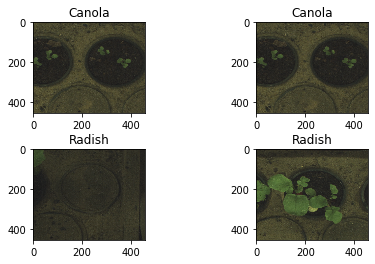

In [13]:
for i in range(2):
    img = plt.imread(train_data.imgs[i][0])
    plt.subplots_adjust(wspace=1, hspace=0.4)
    plt.subplot(2,2,i+1)   
    plt.imshow(img, aspect='auto' , cmap='viridis');
    plt.title('%s' % IdxtoClass(train_data.imgs[i][1])) #The second index if is 1 return the label
   
    img = plt.imread(train_data.imgs[-(i+1)][0])
    plt.subplot(2,2,i+3)
    plt.imshow(img, aspect='auto' , cmap='viridis');
    plt.title('%s' % IdxtoClass(train_data.imgs[-(i+1)][1])) #The second index if is 1 return the label

plt.show()

Data size

In [14]:
img = plt.imread(train_data.imgs[0][0]) # The second index if is 0 return the file name
IMSHAPE= img.shape
IMSHAPE

(456, 456, 3)

In [15]:
len(train_data.imgs)

12000

### Training and Validating

#### Training and validation function

In [16]:
def train_model(model, criterion, optimizer, lr_scheduler, EPOCH):
        print(str(datetime.now()).split('.')[0], "Starting training and validation...\n")
        print("====================Data and Hyperparameter Overview====================\n")
        print("Number of training examples: {} , Number of validation examples: {} ".format(len(train_data), len(valid_data)))
        print("Learning rate: {:,.5f}".format(learning_rate))
        print("================================Results...==============================\n")

        since = time.time()  #record the beginning time

        best_model = model
        best_acc = 0.0
        acc_vect =[]   

        for epoch in range(EPOCH):
            for i, (images, labels) in enumerate(train_loader):   
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()

                # Forward pass
                if epoch==0:
                    outputs, aux = model(images)            # model output
                elif epoch!=0:
                    outputs = model(images)
                loss = criterion(outputs, labels)  # cross entropy loss

                # Trying binary cross entropy
                #loss = criterion(torch.max(outputs.data, 1), labels)
                #loss = torch.nn.functional.binary_cross_entropy(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()             # clear gradients for this training step
                loss.backward()                   # backpropagation, compute gradients
                optimizer.step()                  # apply gradients

                if (i+1) % 500 == 0:               # Reporting the loss and progress every 50 step
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                               .format(epoch+1, EPOCH, i+1, len(train_loader), loss.item()))

            model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    
                    images = Variable(images).cuda()
                    labels = Variable(labels).cuda()

                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)

                    loss = criterion(outputs, labels)
                    loss += loss.item()

                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                epoch_loss= loss / total
                epoch_acc = 100 * correct / total
                acc_vect.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)

                print('Validation accuracy and loss of the model on the test {} images: {} %, {:.5f}'
                      .format(len(valid_data), 100 * correct / total, loss))

            correct = 0
            total = 0
            for images, labels in train_loader:
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)
                loss += loss.item()

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss= loss / total
            epoch_acc = 100 * correct / total

            print('Train  accuracy and loss of the model on the test {} images: {} %, {:.5f}'
                  .format(len(train_data), epoch_acc, loss))
            print('-' * 10)

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best validation Acc: {:4f}'.format(best_acc)) 
        
        mean_acc = np.mean(acc_vect)
        print('Average accuracy on the validation {} images: {}'
              .format(len(train_data),mean_acc))
        print('-' * 10)
        return best_model, mean_acc

### Testing function

In [17]:
def test_model(model, test_loader):
    print("Starting testing...\n")
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    with torch.no_grad():
        correct = 0
        total = 0
        test_loss_vect=[]
        test_acc_vect=[]
        
        since = time.time()  #record the beginning time
        
        for i in range(10):
            
            Indx = torch.randperm(len(test_data))
            Cut=int(len(Indx)/10) # Here 10% showing the proportion of data is chosen for pooling
            indices=Indx[:Cut]            
            Sampler = Data.SubsetRandomSampler(indices)
            pooled_data =  torch.utils.data.DataLoader(test_data , batch_size=BchSz,sampler=Sampler)

            for images, labels in pooled_data:
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            test_loss= loss / total
            test_accuracy= 100 * correct / total
            
            test_loss_vect.append(test_loss)
            test_acc_vect.append(test_accuracy)

            
            print('Test accuracy and loss for the {}th pool: {:.2f} %, {:.5f}'
                  .format(i+1, test_accuracy, test_loss))
            
        
        mean_test_loss = torch.mean(torch.tensor(test_loss_vect))
        mean_test_acc = torch.mean(torch.tensor(test_acc_vect))
        std_test_acc = torch.std(torch.tensor(test_acc_vect))
        
        print('-' * 10)
        print('Average of ten test accuracies on test data: {:.2f} %, loss: {:.5f}, Standard deviion of accuracy: {:.4f}'
              .format(mean_test_acc, mean_test_loss, std_test_acc))
        
        print('-' * 10)
        time_elapsed = time.time() - since
        print('Testing complete in {:.1f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        print('-' * 10)
        
        return mean_test_acc, mean_test_loss, std_test_acc

### Inception network model 

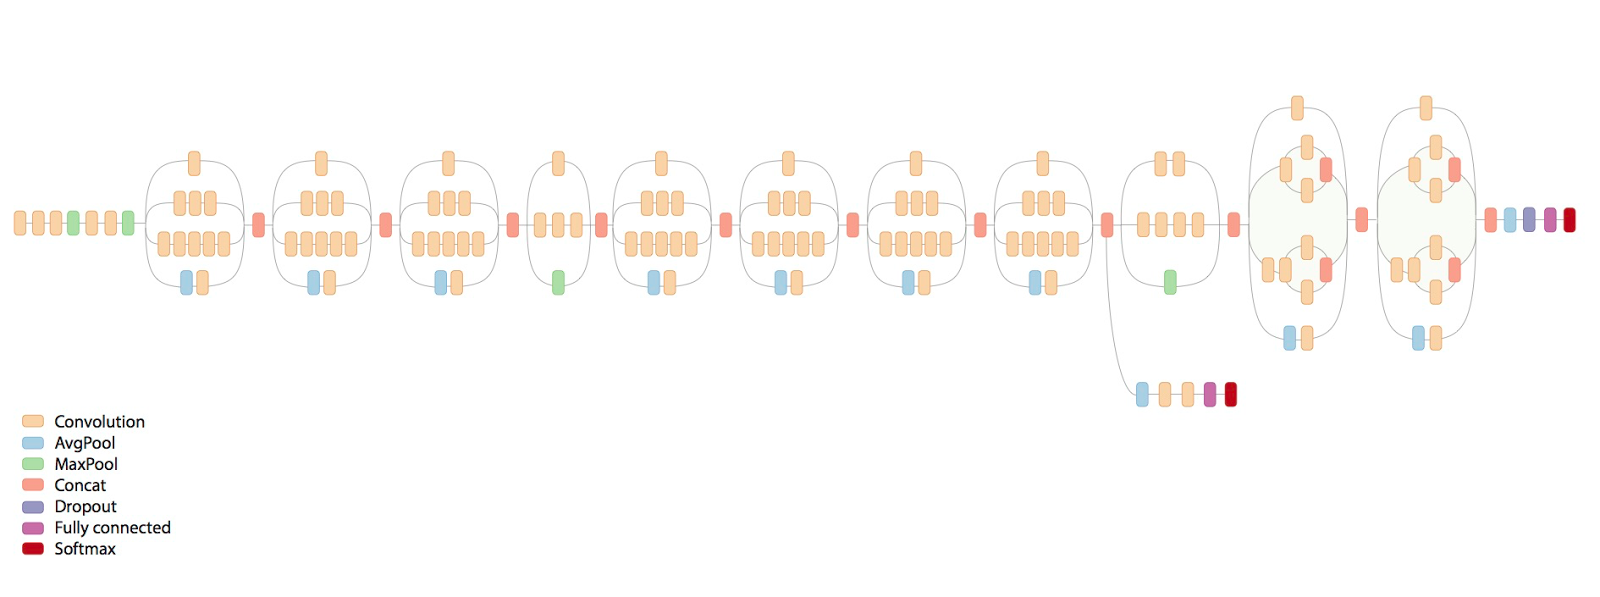

In [18]:
model = models.inception_v3(pretrained=False)
model = model.cuda()
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [19]:
def get_num_params(model):
    TotalParam=0
    for param in list(model.parameters()):
        nn=1
        for size in list(param.size()):
            nn = nn*size
        TotalParam += nn
    return TotalParam

In [20]:
print(get_num_params(model))

27161264


In [21]:
criterion = nn.CrossEntropyLoss()   # cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


train_model(model, criterion, optimizer, lr_scheduler, EPOCH)
test_model (model, test_loader)

2020-01-08 15:23:35 Starting training and validation...

====================Data and Hyperparameter Overview====================

Number of training examples: 12000 , Number of validation examples: 4000 
Learning rate: 0.00010
================================Results...==============================

Epoch [1/5], Step [500/3000], Loss: 2.1526
Epoch [1/5], Step [1000/3000], Loss: 1.2408
Epoch [1/5], Step [1500/3000], Loss: 0.8934
Epoch [1/5], Step [2000/3000], Loss: 0.4791
Epoch [1/5], Step [2500/3000], Loss: 2.0105
Epoch [1/5], Step [3000/3000], Loss: 0.0979
Validation accuracy and loss of the model on the test 4000 images: 66.075 %, 0.56079
Train  accuracy and loss of the model on the test 12000 images: 71.26666666666667 %, 1.42583
----------
Epoch [2/5], Step [500/3000], Loss: 1.0408
Epoch [2/5], Step [1000/3000], Loss: 1.6062
Epoch [2/5], Step [1500/3000], Loss: 0.4272
Epoch [2/5], Step [2000/3000], Loss: 0.6645
Epoch [2/5], Step [2500/3000], Loss: 0.5375
Epoch [2/5], Step [3000/300

(tensor(83.2509), tensor(0.0002), tensor(0.4353))